# Import Library

In [42]:
# 기본 패키지
import numpy as np
import pandas as pd

# 군집화 패키지
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

# 표준화 패키지
from sklearn.preprocessing import StandardScaler

# 경고 무시
import warnings
warnings.filterwarnings(action='ignore')

# 시각화 패키지
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from mpl_toolkits.mplot3d import Axes3D


# 한글폰트 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

# 데이터 경로 설정
data_path = '../data/LPOINT_BIG_COMP/LPOINT_BIG_COMP_'

# Data Load

In [2]:
# 데이터 불러오기
demo = pd.read_csv(data_path + '01_DEMO.csv', low_memory=False)
pdde = pd.read_csv(data_path + '02_PDDE.csv', low_memory=False)
cop = pd.read_csv(data_path + '03_COP_U.csv', low_memory=False)
clac = pd.read_csv(data_path + '04_PD_CLAC.csv', low_memory=False)
br = pd.read_csv(data_path + '05_BR.csv', low_memory=False)
lpay = pd.read_csv(data_path + '06_LPAY.csv', low_memory=False)

# Data PreProcessing

In [3]:
# Column명 변경
demo.columns = ['고객번호', '성별', '연령대', '거주지대분류코드']
pdde.columns = ['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '구매시간', '구매금액', '구매수량']
cop.columns = ['고객번호', '영수증번호', '제휴사', '점포코드', '채널구분', '이용일자', '방문일자', '이용시간', '이용금액']
clac.columns = ['상품코드', '소분류명', '대분류명', '중분류명']
br.columns = ['점포코드', '제휴사', '점포대분류코드', '점포중분류코드']
lpay.columns = ['고객번호', '영수증번호', '제휴사', '채널구분', '이용일자', '이용시간', '이용금액']

### [1. demo]: Demo

In [4]:
demo

,고객번호,성별,연령대,거주지대분류코드
0,M000034966,여성,40대,Z07
1,M000059535,여성,30대,Z12
2,M000136117,여성,30대,Z11
3,M000201112,여성,50대,Z17
4,M000225114,여성,40대,Z17
...,...,...,...,...
29908,M999708287,여성,40대,Z10
29909,M999770689,여성,30대,Z16
29910,M999849895,여성,20대,Z04
29911,M999926092,남성,30대,Z08


### [2. pdde]: 상품 구매 정보

In [5]:
pdde

,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1
...,...,...,...,...,...,...,...,...,...,...
4381738,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1
4381739,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1
4381740,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1
4381741,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1


In [6]:
# 중복되는 행 제거
pdde.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

In [7]:
# 결측치 확인
pdde.isna().sum()

고객번호          0
영수증번호         0
채널구분          0
제휴사           0
점포코드     375784
상품코드          0
구매일자          0
구매시간          0
구매금액          0
구매수량          0
dtype: int64

In [8]:
# 상품 구매 정보 테이블 내에 점포 코드 결측치는 온라인으로 주문한 것을 확인할 수 있음. 온라인으로 주문한 뒤에 택배로 수령
pdde[pdde['점포코드'].isna()]['채널구분'].unique()

array([2])

In [9]:
# 결측치 치환
pdde['점포코드'] = pdde['점포코드'].fillna('온라인')

### [3. cop]: 제휴사 이용 정보

In [10]:
cop

,고객번호,영수증번호,제휴사,점포코드,채널구분,이용일자,방문일자,이용시간,이용금액
0,M839993508,21102612B015763935,B01,B010012,1,20211026,20211026,12,60000
1,M839993508,21110610B014219744,B01,B010012,1,20211106,20211106,10,17100
2,M839993508,21021112B013419710,B01,B010012,1,20210211,20210211,12,136500
3,M839993508,21092010B012637545,B01,B010012,1,20210920,20210920,10,34200
4,M839993508,21101009D015920171,D01,D010614,1,20211010,20211010,9,2500
...,...,...,...,...,...,...,...,...,...
248299,M058650684,21111614C021426818,C02,C020002,1,20211116,20211116,14,2000
248300,M058650684,21111619C023223432,C02,C020002,1,20211116,20211116,19,26900
248301,M014154595,21121209C015324520,C01,C010087,2,20211212,20211212,9,2000
248302,M510878172,21112719C013369102,C01,C010007,2,20211127,20211127,19,6000


In [11]:
# 결측치 확인
cop.isna().sum()

고객번호      0
영수증번호     0
제휴사       0
점포코드     55
채널구분      0
이용일자      0
방문일자      0
이용시간      0
이용금액      0
dtype: int64

In [12]:
# 제휴사 이용 정보 테이블 내에 점포 코드 결측치는 온라인으로 주문한 것을 확인할 수 있음. 온라인으로 주문한 뒤에 택배로 수령
cop[cop['점포코드'].isna()]['채널구분'].unique()

array([2])

In [13]:
# 결측치 치환
cop['점포코드'] = cop['점포코드'].fillna('온라인')

### [4. clac]: 상품 분류 정보

In [14]:
clac

,상품코드,소분류명,대분류명,중분류명
0,PD0001,소파,가구,거실가구
1,PD0002,스툴/리빙의자,가구,거실가구
2,PD0003,탁자,가구,거실가구
3,PD0004,장식장/진열장,가구,거실가구
4,PD0005,기타가구,가구,기타가구
...,...,...,...,...
1928,PD1929,여성향수,화장품/뷰티케어,향수
1929,PD1930,남성향수,화장품/뷰티케어,향수
1930,PD1931,남녀공용향수,화장품/뷰티케어,향수
1931,PD1932,남성향수세트,화장품/뷰티케어,향수


### [5. br]: 점포 정보

In [15]:
br

,점포코드,제휴사,점포대분류코드,점포중분류코드
0,A010001,A01,Z17,Z17024
1,A010002,A01,Z17,Z17018
2,A010003,A01,Z17,Z17011
3,A010004,A01,Z16,Z16007
4,A010005,A01,Z17,Z17005
...,...,...,...,...
8803,E010040,E01,Z17,Z17024
8804,E010041,E01,Z16,Z16005
8805,E010042,E01,Z17,Z17021
8806,E010043,E01,Z10,Z10035


### [6. lpay]: 엘페이 이용

In [16]:
lpay

,고객번호,영수증번호,제휴사,채널구분,이용일자,이용시간,이용금액
0,M629656521,210803210311226,A03,1,20210803,21,10900
1,M216016456,210803130167542,L01,2,20210803,13,6860
2,M205142844,210803140275112,A02,1,20210803,14,9000
3,M737010483,210803040637594,A06,2,20210803,4,36740
4,M707775545,210803140675502,A06,2,20210803,14,138500
...,...,...,...,...,...,...,...
353179,M470112503,210125110644545,A06,2,20210125,11,51800
353180,M470112503,210104210652271,A06,2,20210104,21,6440
353181,M748878049,210119200278240,A02,1,20210119,20,17600
353182,M748878049,210119180267206,A02,1,20210119,18,12400


# Data Merge

In [17]:
# 데이터를 통합하기 위하여 칼럼 통합
pdde['타입'] = 'Product'
cop['타입'] = 'Affiliate'
lpay['타입'] = 'Lpay'
pdde['방문일자'] = 0
lpay['방문일자'] = 0
cop['구매수량'] = 0
cop['상품코드'] = np.nan
lpay['점포코드'] = np.nan
lpay['상품코드'] = np.nan
lpay['구매수량'] = 0

In [18]:
# 칼럼명을 새롭게 동일하게 통일
cop.columns = ['고객번호', '영수증번호', '제휴사', '점포코드', '채널구분', '구매일자', '방문일자', '구매시간', '구매금액', '타입', '구매수량', '상품코드']
lpay.columns = ['고객번호', '영수증번호', '제휴사', '채널구분', '구매일자', '구매시간', '구매금액', '타입', '방문일자', '점포코드', '상품코드', '구매수량']

In [19]:
# 상품구매데이터를 기준으로 하여 열을 통일
cop = cop[['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '방문일자', '구매시간', '구매금액', '구매수량', '타입']]
lpay = lpay[['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '방문일자', '구매시간', '구매금액', '구매수량', '타입']]

In [20]:
# 데이터 타입 변경
lpay['영수증번호'] = lpay['영수증번호'].astype('object')
lpay['점포코드'] = lpay['점포코드'].astype('object')
cop['상품코드'] = cop['상품코드'].astype('object')
lpay['상품코드'] = lpay['상품코드'].astype('object')
pdde['구매금액'] = pdde['구매금액'].astype('int')
pdde['방문일자'] = pdde['방문일자'].astype('int64')
lpay['방문일자'] = lpay['방문일자'].astype('int64')

In [21]:
# 데이터 concat
df = pd.concat([pdde,cop,lpay])

In [22]:
# 고객 정보 테이븛 통합
df = pd.merge(df, demo, on = ['고객번호'], how = 'left')

In [23]:
# 상품 분류 테이블 통합
df = pd.merge(df, br, on = ['점포코드','제휴사'], how = 'left')

In [24]:
# 점포 정보 테이블 통합
df = pd.merge(df, clac, on = ['상품코드'], how = 'left')

In [25]:
data = df.copy()

In [26]:
# 데이터 분리
df1 = data[data['타입']== 'Product']
df2 = data[data['타입']== 'Affiliate']
df3 = data[data['타입']== 'Lpay']

In [27]:
customer_id = df.groupby('고객번호')[['구매일자']].max().index.tolist()
recency = df.groupby('고객번호')[['구매일자']].max()['구매일자'].tolist()
frequency = df.groupby('고객번호')[['영수증번호']].count()['영수증번호'].tolist()
monetary = df.groupby('고객번호')[['구매금액']].sum()['구매금액'].tolist()

df_rfm = pd.DataFrame({'Customer_ID': customer_id, 'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})

In [28]:
df_rfm['Recency'] = df_rfm['Recency'].astype(str)
df_rfm['Recency'] = pd.to_datetime(df_rfm['Recency'])
df_rfm['Recency'] = df_rfm['Recency'] - pd.to_datetime('20210101')
df_rfm['Recency'] = [x.total_seconds() for x in df_rfm['Recency']]
df_rfm

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,30758400.0,49,616240
1,M000059535,5270400.0,1,46000
2,M000136117,31363200.0,121,28697031
3,M000201112,28598400.0,20,51420
4,M000225114,31449600.0,163,2084270
...,...,...,...,...
29869,M999708287,21081600.0,2,60000
29870,M999770689,31449600.0,402,2078770
29871,M999849895,28857600.0,70,1095312
29872,M999926092,28944000.0,7,129500


In [29]:
scaler = StandardScaler()
scaler.fit(df_rfm.iloc[:,1:])

rfm_scaled = scaler.transform(df_rfm.iloc[:,1:]) 

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns = df_rfm.iloc[:,1:].columns) 
rfm_scaled_df.insert(0, 'Customer_ID', df_rfm['Customer_ID'])
rfm_scaled_df

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,0.473152,-0.485098,-0.267824
1,M000059535,-3.840668,-0.697040,-0.310240
2,M000136117,0.575514,-0.167184,1.820935
3,M000201112,0.107574,-0.613146,-0.309837
4,M000225114,0.590137,0.018266,-0.158626
...,...,...,...,...
29869,M999708287,-1.164637,-0.692625,-0.309199
29870,M999770689,0.590137,1.073564,-0.159035
29871,M999849895,0.151443,-0.392373,-0.232188
29872,M999926092,0.166066,-0.670547,-0.304029


# Data Clustering

- elbow point

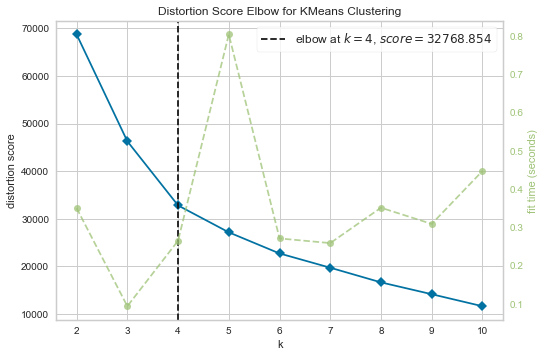

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
kmeans = KMeans(random_state = np.random.RandomState(seed=42))

elb_visualizer = KElbowVisualizer(kmeans, k = (2,11))
elb_visualizer.fit(rfm_scaled_df.iloc[:,1:])
elb_visualizer.show()

- silhouette score

In [44]:
si = []

def silhouette(X):
    for i in range(2,11):
        km = KMeans(n_clusters=i, init='k-means++', random_state = np.random.RandomState(seed=42))
        km.fit(X)
        si.append(np.round(silhouette_score(X, km.labels_), 3))
    
silhouette(rfm_scaled_df.iloc[:,1:])

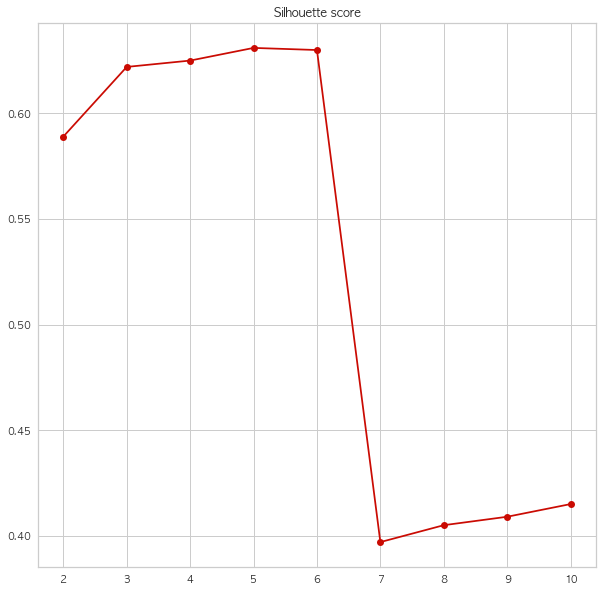

In [45]:
fig = plt.figure(figsize=(10, 10))
plt.plot(range(2, 11), si, marker = 'o', color = 'r')
plt.grid(True)
plt.title('Silhouette score')
plt.show()

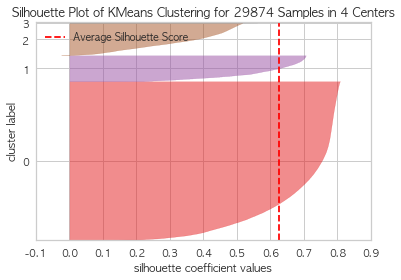

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 29874 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [46]:
model_4clust = KMeans(n_clusters = 4, random_state=np.random.RandomState(seed=42))

sil_visualizer = SilhouetteVisualizer(model_4clust)
sil_visualizer.fit(rfm_scaled_df.iloc[:,1:])
sil_visualizer.show()

- cluster labeling

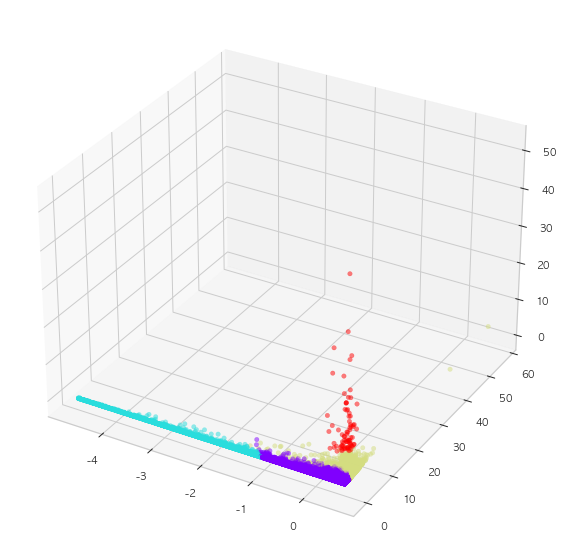

In [47]:
kmeans = KMeans(n_clusters = 4, random_state = np.random.RandomState(seed=42))
labels = kmeans.fit_predict(rfm_scaled_df.iloc[:,1:])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = rfm_scaled_df['Recency']
y = rfm_scaled_df['Frequency']
z = rfm_scaled_df['Monetary']
ax.scatter(x, y, z, c = labels, s= 20, alpha=0.5, cmap='rainbow')

In [48]:
rfm_scaled_df['labels'] = labels
rfm_df = rfm_scaled_df[['Customer_ID', 'labels']]
rfm_df.columns = ['고객번호', 'labels']
rfm_df

,고객번호,labels
0,M000034966,0
1,M000059535,1
2,M000136117,0
3,M000201112,0
4,M000225114,0
...,...,...
29869,M999708287,1
29870,M999770689,2
29871,M999849895,0
29872,M999926092,0


- data merge

In [49]:
df = pd.merge(df, rfm_df, on = ['고객번호'], how = 'left')
df

,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,성별,연령대,거주지대분류코드,점포대분류코드,점포중분류코드,소분류명,대분류명,중분류명,labels_x,labels_y
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000,1,...,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류,남성의류상의,2,2
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700,1,...,여성,40대,Z13,Z13,Z13001,기타주방일회용품,주방잡화,주방일회용품,2,2
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000,1,...,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류,남성의류상의,2,2
3,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000,1,...,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류,남성의류상의,2,2
4,M430112881,A01000005297,1,A01,A010039,PD1692,20210101,10,9900,1,...,여성,50대,Z17,Z10,Z10042,커피/음료,테넌트/음식점,식당,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4745872,M470112503,210125110644545,2,A06,NaN,NaN,20210125,11,51800,0,...,여성,50대,Z16,NaN,NaN,NaN,NaN,NaN,2,2
4745873,M470112503,210104210652271,2,A06,NaN,NaN,20210104,21,6440,0,...,여성,50대,Z16,NaN,NaN,NaN,NaN,NaN,2,2
4745874,M748878049,210119200278240,1,A02,NaN,NaN,20210119,20,17600,0,...,여성,30대,Z10,NaN,NaN,NaN,NaN,NaN,1,0
4745875,M748878049,210119180267206,1,A02,NaN,NaN,20210119,18,12400,0,...,여성,30대,Z10,NaN,NaN,NaN,NaN,NaN,1,0


# Train-Test-Split

- 고객번호 별로 영수증번호 횟수를 고려하여 고르게 train, test로 분할

In [54]:
df_customer = pd.DataFrame(df.groupby('고객번호')[['영수증번호']].count()).reset_index()
df_customer

,고객번호,영수증번호
0,M000034966,49
1,M000059535,1
2,M000136117,121
3,M000201112,20
4,M000225114,163
...,...,...
29869,M999708287,2
29870,M999770689,402
29871,M999849895,70
29872,M999926092,7


In [55]:
df_customer['영수증번호'].describe()

count    29874.000000
mean       158.863125
std        226.480154
min          1.000000
25%         20.000000
50%         83.000000
75%        211.000000
max      13120.000000
Name: 영수증번호, dtype: float64

- 0% ~ 25%

In [59]:
df_customer1 = df_customer[df_customer['영수증번호'] < df_customer['영수증번호'].quantile(0.25)]
df_customer1

,고객번호,영수증번호
1,M000059535,1
11,M000555652,17
13,M000608261,5
15,M000658311,4
17,M000713279,1
...,...,...
29862,M999441814,7
29864,M999492154,5
29865,M999493501,3
29869,M999708287,2


In [65]:
train1 = df_customer1.iloc[:int(0.7*len(df_customer1))]
test1 = df_customer1.iloc[int(0.7*len(df_customer1)):]
print(train1.shape, test1.shape)

(5224, 2) (2240, 2)


- 25% ~ 50%

In [60]:
df_customer2 = df_customer[df_customer['영수증번호'] >= df_customer['영수증번호'].quantile(0.25)]
df_customer2 = df_customer2[df_customer2['영수증번호'] < df_customer['영수증번호'].quantile(0.5)]
df_customer2

,고객번호,영수증번호
0,M000034966,49
3,M000201112,20
5,M000261625,67
6,M000350564,32
10,M000508243,37
...,...,...
29857,M999227380,70
29859,M999268192,56
29863,M999468256,54
29868,M999673157,24


In [69]:
train2 = df_customer2.iloc[:int(0.7*len(df_customer2))]
test2 = df_customer2.iloc[int(0.7*len(df_customer2)):]
print(train2.shape, test2.shape)

(5215, 2) (2236, 2)


- 50% ~ 75%

In [61]:
df_customer3 = df_customer[df_customer['영수증번호'] >= df_customer['영수증번호'].quantile(0.5)]
df_customer3 = df_customer3[df_customer3['영수증번호'] < df_customer['영수증번호'].quantile(0.75)]
df_customer3

,고객번호,영수증번호
2,M000136117,121
4,M000225114,163
7,M000419293,117
9,M000504230,188
14,M000621637,200
...,...,...
29849,M999048029,130
29853,M999153368,88
29855,M999181273,84
29858,M999238704,188


In [70]:
train3 = df_customer3.iloc[:int(0.7*len(df_customer3))]
test3 = df_customer3.iloc[int(0.7*len(df_customer3)):]
print(train3.shape, test3.shape)

(5218, 2) (2237, 2)


- 75% ~ 100%

In [62]:
df_customer4 = df_customer[df_customer['영수증번호'] >= df_customer['영수증번호'].quantile(0.75)]
df_customer4

,고객번호,영수증번호
8,M000494848,472
12,M000557840,344
16,M000705571,318
26,M001231653,228
28,M001332751,401
...,...,...
29848,M999002436,292
29856,M999213998,442
29866,M999515910,521
29870,M999770689,402


In [71]:
train4 = df_customer4.iloc[:int(0.7*len(df_customer4))]
test4 = df_customer4.iloc[int(0.7*len(df_customer4)):]
print(train4.shape, test4.shape)

(5252, 2) (2252, 2)


- concat

In [73]:
train = pd.concat([train1, train2, train3, train4], axis = 0)
test = pd.concat([test1, test2, test3, test4], axis = 0)

In [79]:
df_train = df[df['고객번호'].isin(train['고객번호'].tolist())]
df_test = df[df['고객번호'].isin(test['고객번호'].tolist())]
print(df_train.shape, df_test.shape)

(3305368, 22) (1440509, 22)
